In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll, make_moons
from tqdm import tqdm
from typing import Literal

torch.set_float32_matmul_precision('high')

# ==========================================
# 1. Configuration
# ==========================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

INTRINSIC_DIM = 2      # true manifold dimension
AMBIENT_DIM = 32      # high-dimensional ambient space

print(f"Running on {DEVICE} with Ambient Dimension D={AMBIENT_DIM}")

Running on cuda:7 with Ambient Dimension D=32


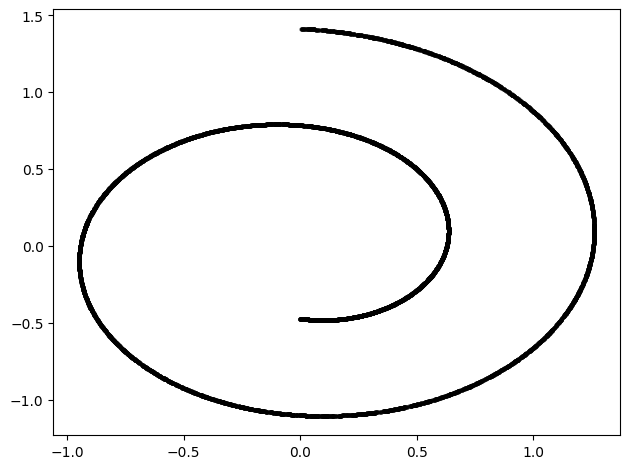

In [2]:
# ==========================================
# 2. Data + Random Orthogonal Embedding
# ==========================================
def get_data(batch_size: int, data_type: str) -> np.ndarray:
    if data_type == "swiss_roll":
        data, _ = make_swiss_roll(batch_size)
        data = data[:, [0, 2]] / 10.0
    elif data_type == "moons":
        data, _ = make_moons(batch_size)
    return data

# random orthogonal projection 2 → D
Q = torch.randn(AMBIENT_DIM, INTRINSIC_DIM, device=DEVICE)
Q, _ = torch.linalg.qr(Q)

def embed(x2d):
    return x2d @ Q.T

def project_back(xD):
    return xD @ Q

n_points = 8192
data_type = "swiss_roll"
data = get_data(n_points, data_type)

plt.scatter(data[:,0], data[:,1], s=5, c='black', alpha=0.5)
plt.tight_layout()
plt.show()

In [3]:
batch_size = 1024
dataset = torch.from_numpy(data).float().to(DEVICE)
dataset = TensorDataset(dataset) 
# dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=8, prefetch_factor=4)
dataloader = DataLoader(dataset, batch_size=batch_size)

In [4]:
# ==========================================
# 3. Model (MLP)
# ==========================================
class DenoisingMLP(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.time_encoder = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
        )

        self.net = nn.Sequential(
            nn.Linear(dim + 20, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, z_t, t):
        t_emb = self.time_encoder(t)
        out = self.net(torch.cat((z_t, t_emb), dim=-1))
        return out


class MLPGlobalResidual(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.time_encoder = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
        )

        self.net = nn.Sequential(
            nn.Linear(dim + 20, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, z_t, t):
        t_emb = self.time_encoder(t)
        out = self.net(torch.cat((z_t, t_emb), dim=-1))
        return out + z_t


class MLPCorrectedResidual1(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.time_encoder = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
        )

        self.net = nn.Sequential(
            nn.Linear(dim + 20, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, z_t, t):
        t_emb = self.time_encoder(t)
        out = self.net(torch.cat((z_t, t_emb), dim=-1))
        return out + z_t/ (1 - t)


class MLPCorrectedResidual2(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.time_encoder = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
        )

        self.net = nn.Sequential(
            nn.Linear(dim + 20, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, z_t, t):
        t_emb = self.time_encoder(t)
        out = self.net(torch.cat((z_t, t_emb), dim=-1))
        return (t * out + z_t) / (1 - t)



In [5]:
# ==================================================
# 4. Loss (x, eps, v prediction) * (x, eps, v loss)
# ==================================================
def compute_loss(x1, eps, xt, t, pred_raw, pred_type, loss_type):
    if loss_type == "v":
        if pred_type == "x":
            x1_hat = pred_raw
            v_hat = (x1_hat - xt) / (1-t)
        elif pred_type == "eps":
            eps_hat = pred_raw
            v_hat = (xt - eps_hat) / t
        elif pred_type == "v":
            v_hat = pred_raw
        v_target = x1 - eps
        return ((v_hat - v_target)**2).mean()
    
    elif loss_type == "x":
        if pred_type == "x":
            x1_hat = pred_raw
        elif pred_type == "eps":
            eps_hat = pred_raw
            x1_hat = (xt - eps_hat*(1-t)) / t
        elif pred_type == "v":
            v_hat = pred_raw
            x1_hat = xt + (1 - t) * v_hat
        return ((x1_hat - x1)**2).mean()

    elif loss_type == "eps":
        if pred_type == "x":
            x1_hat = pred_raw
            eps_hat = (xt - t*x1_hat) / (1 - t)
        elif pred_type == "eps":
            eps_hat = pred_raw
        elif pred_type == "v":
            v_hat = pred_raw
            eps_hat = xt - t * v_hat
        return ((eps_hat - eps)**2).mean()

In [6]:
# ==========================================
# 5. Training (x, eps, v prediction)
# ==========================================
def train_model(pred_type="x", loss_type="v", model_arch: Literal["vanilla", "global_residual", "corrected_residual1", "corrected_residual2"] = "vanilla", hidden_dim=256, train_steps=1000):
    assert pred_type in ["x", "eps", "v"]
    assert loss_type in ["x", "eps", "v"]
    model_cls = {
        "vanilla": DenoisingMLP,
        "global_residual": MLPGlobalResidual,
        "corrected_residual1": MLPCorrectedResidual1,
        "corrected_residual2": MLPCorrectedResidual2,
    }[model_arch]
    model = model_cls(AMBIENT_DIM, hidden_dim).to(DEVICE)
    optim_ = optim.Adam(model.parameters(), lr=1e-3)

    print(f"Training {pred_type}-prediction {model_arch} model with {loss_type} loss...")
    t_eps = 1e-2
    losses = []

    @torch.compile(mode="max-autotune")
    def train_step(x1_low):
        x1 = embed(x1_low)
        eps = torch.randn_like(x1)
        t = torch.rand((x1.shape[0], 1), device=DEVICE)
        t = t.clip(t_eps, 1 - t_eps)
        xt = t * x1 + (1 - t) * eps

        pred_raw = model(xt, t)
        
        loss = compute_loss(x1, eps, xt, t, pred_raw, pred_type, loss_type)
        optim_.zero_grad()
        loss.backward()
        optim_.step()

        return loss

    for step in tqdm(range(train_steps)):
        for batch in dataloader:
            x1_low = batch[0].to(DEVICE, non_blocking=True)
            loss = train_step(x1_low)
            losses.append(loss.clone().detach())

    losses = [loss.item() for loss in losses]
    return model, losses

LOSS_TYPE = "v"   # v, x, eps
TRAIN_STEPS = 1000
HIDDEN_DIM = 256

experiments = [
    ("vanilla", "x"),
    ("vanilla", "eps"),
    ("vanilla", "v"),
    ("global_residual", "x"),
    ("global_residual", "eps"),
    ("global_residual", "v"),
    ("corrected_residual1", "x"),
    ("corrected_residual1", "eps"),
    ("corrected_residual1", "v"),
    ("corrected_residual2", "x"),
    ("corrected_residual2", "eps"),
    ("corrected_residual2", "v"),
]

results = {}

for model_arch, pred_type in experiments:
    model, losses = train_model(model_arch=model_arch, pred_type=pred_type, loss_type=LOSS_TYPE, hidden_dim=HIDDEN_DIM, train_steps=TRAIN_STEPS)
    results[(model_arch, pred_type)] = (model, losses)

Training x-prediction vanilla model with v loss...


100%|██████████| 1000/1000 [00:49<00:00, 20.17it/s]


Training eps-prediction vanilla model with v loss...


100%|██████████| 1000/1000 [00:43<00:00, 23.10it/s]


Training v-prediction vanilla model with v loss...


100%|██████████| 1000/1000 [00:43<00:00, 22.99it/s]


Training x-prediction global_residual model with v loss...


100%|██████████| 1000/1000 [00:49<00:00, 20.11it/s]


Training eps-prediction global_residual model with v loss...


100%|██████████| 1000/1000 [00:47<00:00, 20.87it/s]


Training v-prediction global_residual model with v loss...


100%|██████████| 1000/1000 [00:54<00:00, 18.46it/s]


Training x-prediction corrected_residual1 model with v loss...


100%|██████████| 1000/1000 [00:50<00:00, 19.62it/s]


Training eps-prediction corrected_residual1 model with v loss...


100%|██████████| 1000/1000 [00:49<00:00, 20.37it/s]


Training v-prediction corrected_residual1 model with v loss...


  0%|          | 0/1000 [00:00<?, ?it/s]W1124 13:20:10.179000 1973810 torch/_dynamo/convert_frame.py:1358] [0/8] torch._dynamo hit config.recompile_limit (8)
W1124 13:20:10.179000 1973810 torch/_dynamo/convert_frame.py:1358] [0/8]    function: 'train_step' (/tmp/ipykernel_1973810/2220930471.py:20)
W1124 13:20:10.179000 1973810 torch/_dynamo/convert_frame.py:1358] [0/8]    last reason: 0/0: Cache line invalidated because L['optim_'] got deallocated
W1124 13:20:10.179000 1973810 torch/_dynamo/convert_frame.py:1358] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1124 13:20:10.179000 1973810 torch/_dynamo/convert_frame.py:1358] [0/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html
100%|██████████| 1000/1000 [01:09<00:00, 14.39it/s]


Training x-prediction corrected_residual2 model with v loss...


100%|██████████| 1000/1000 [01:20<00:00, 12.39it/s]


Training eps-prediction corrected_residual2 model with v loss...


100%|██████████| 1000/1000 [01:05<00:00, 15.29it/s]


Training v-prediction corrected_residual2 model with v loss...


100%|██████████| 1000/1000 [00:55<00:00, 18.16it/s]


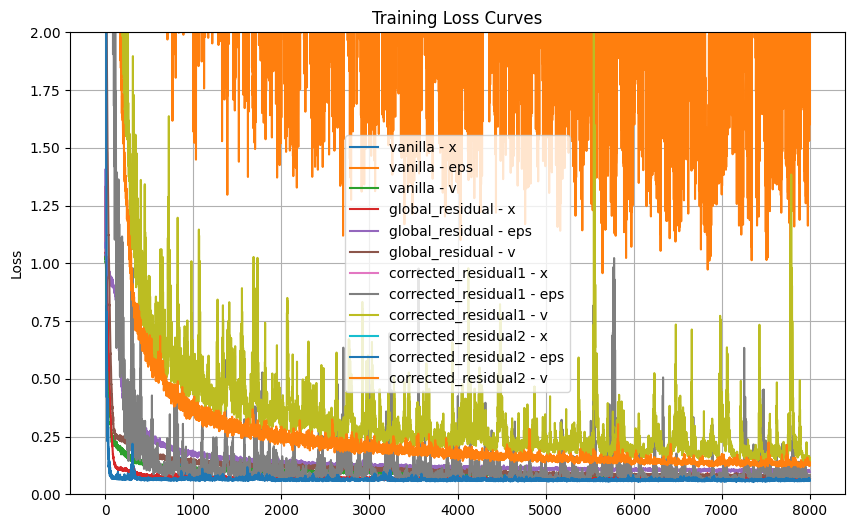

In [7]:
# Visualize the training loss curves
plt.figure(figsize=(10, 6))
for (model_arch, pred_type), (_, losses) in results.items():
    plt.plot(losses, label=f"{model_arch} - {pred_type}")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.ylim(0, 2)
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# ==========================================
# 6. Sampling
# ==========================================
@torch.no_grad()
def sample(model, pred_type, num_samples=2000, steps=50):
    x_t = torch.randn(num_samples, AMBIENT_DIM, device=DEVICE)
    eps_t = 1e-2
    ts = torch.linspace(eps_t, 1 - eps_t, steps, device=DEVICE)
    ts = ts.unsqueeze(0).repeat(num_samples, 1)
    interval = ts[:, 1:2] - ts[:, 0:1]

    for i in range(steps):
        t = ts[:, i:i+1]
        pred_raw = model(x_t, t)

        if pred_type == "x":
            x1_hat = pred_raw
            v_hat = (x1_hat - x_t) / (1-t)
        elif pred_type == "eps":
            eps_hat = pred_raw
            v_hat = (x_t - eps_hat) / t
        elif pred_type == "v":
            v_hat = pred_raw
        x_t = x_t + v_hat * interval

    return x_t


samples = {}
for (model_arch, pred_type), (model, _) in results.items():
    samples[(model_arch, pred_type)] = sample(model, pred_type, num_samples=n_points)

# Project back to 2D
x_orig = data
x_preds = {}
for (model_arch, pred_type), sample in samples.items():
    x_preds[(model_arch, pred_type)] = project_back(sample).cpu().numpy()

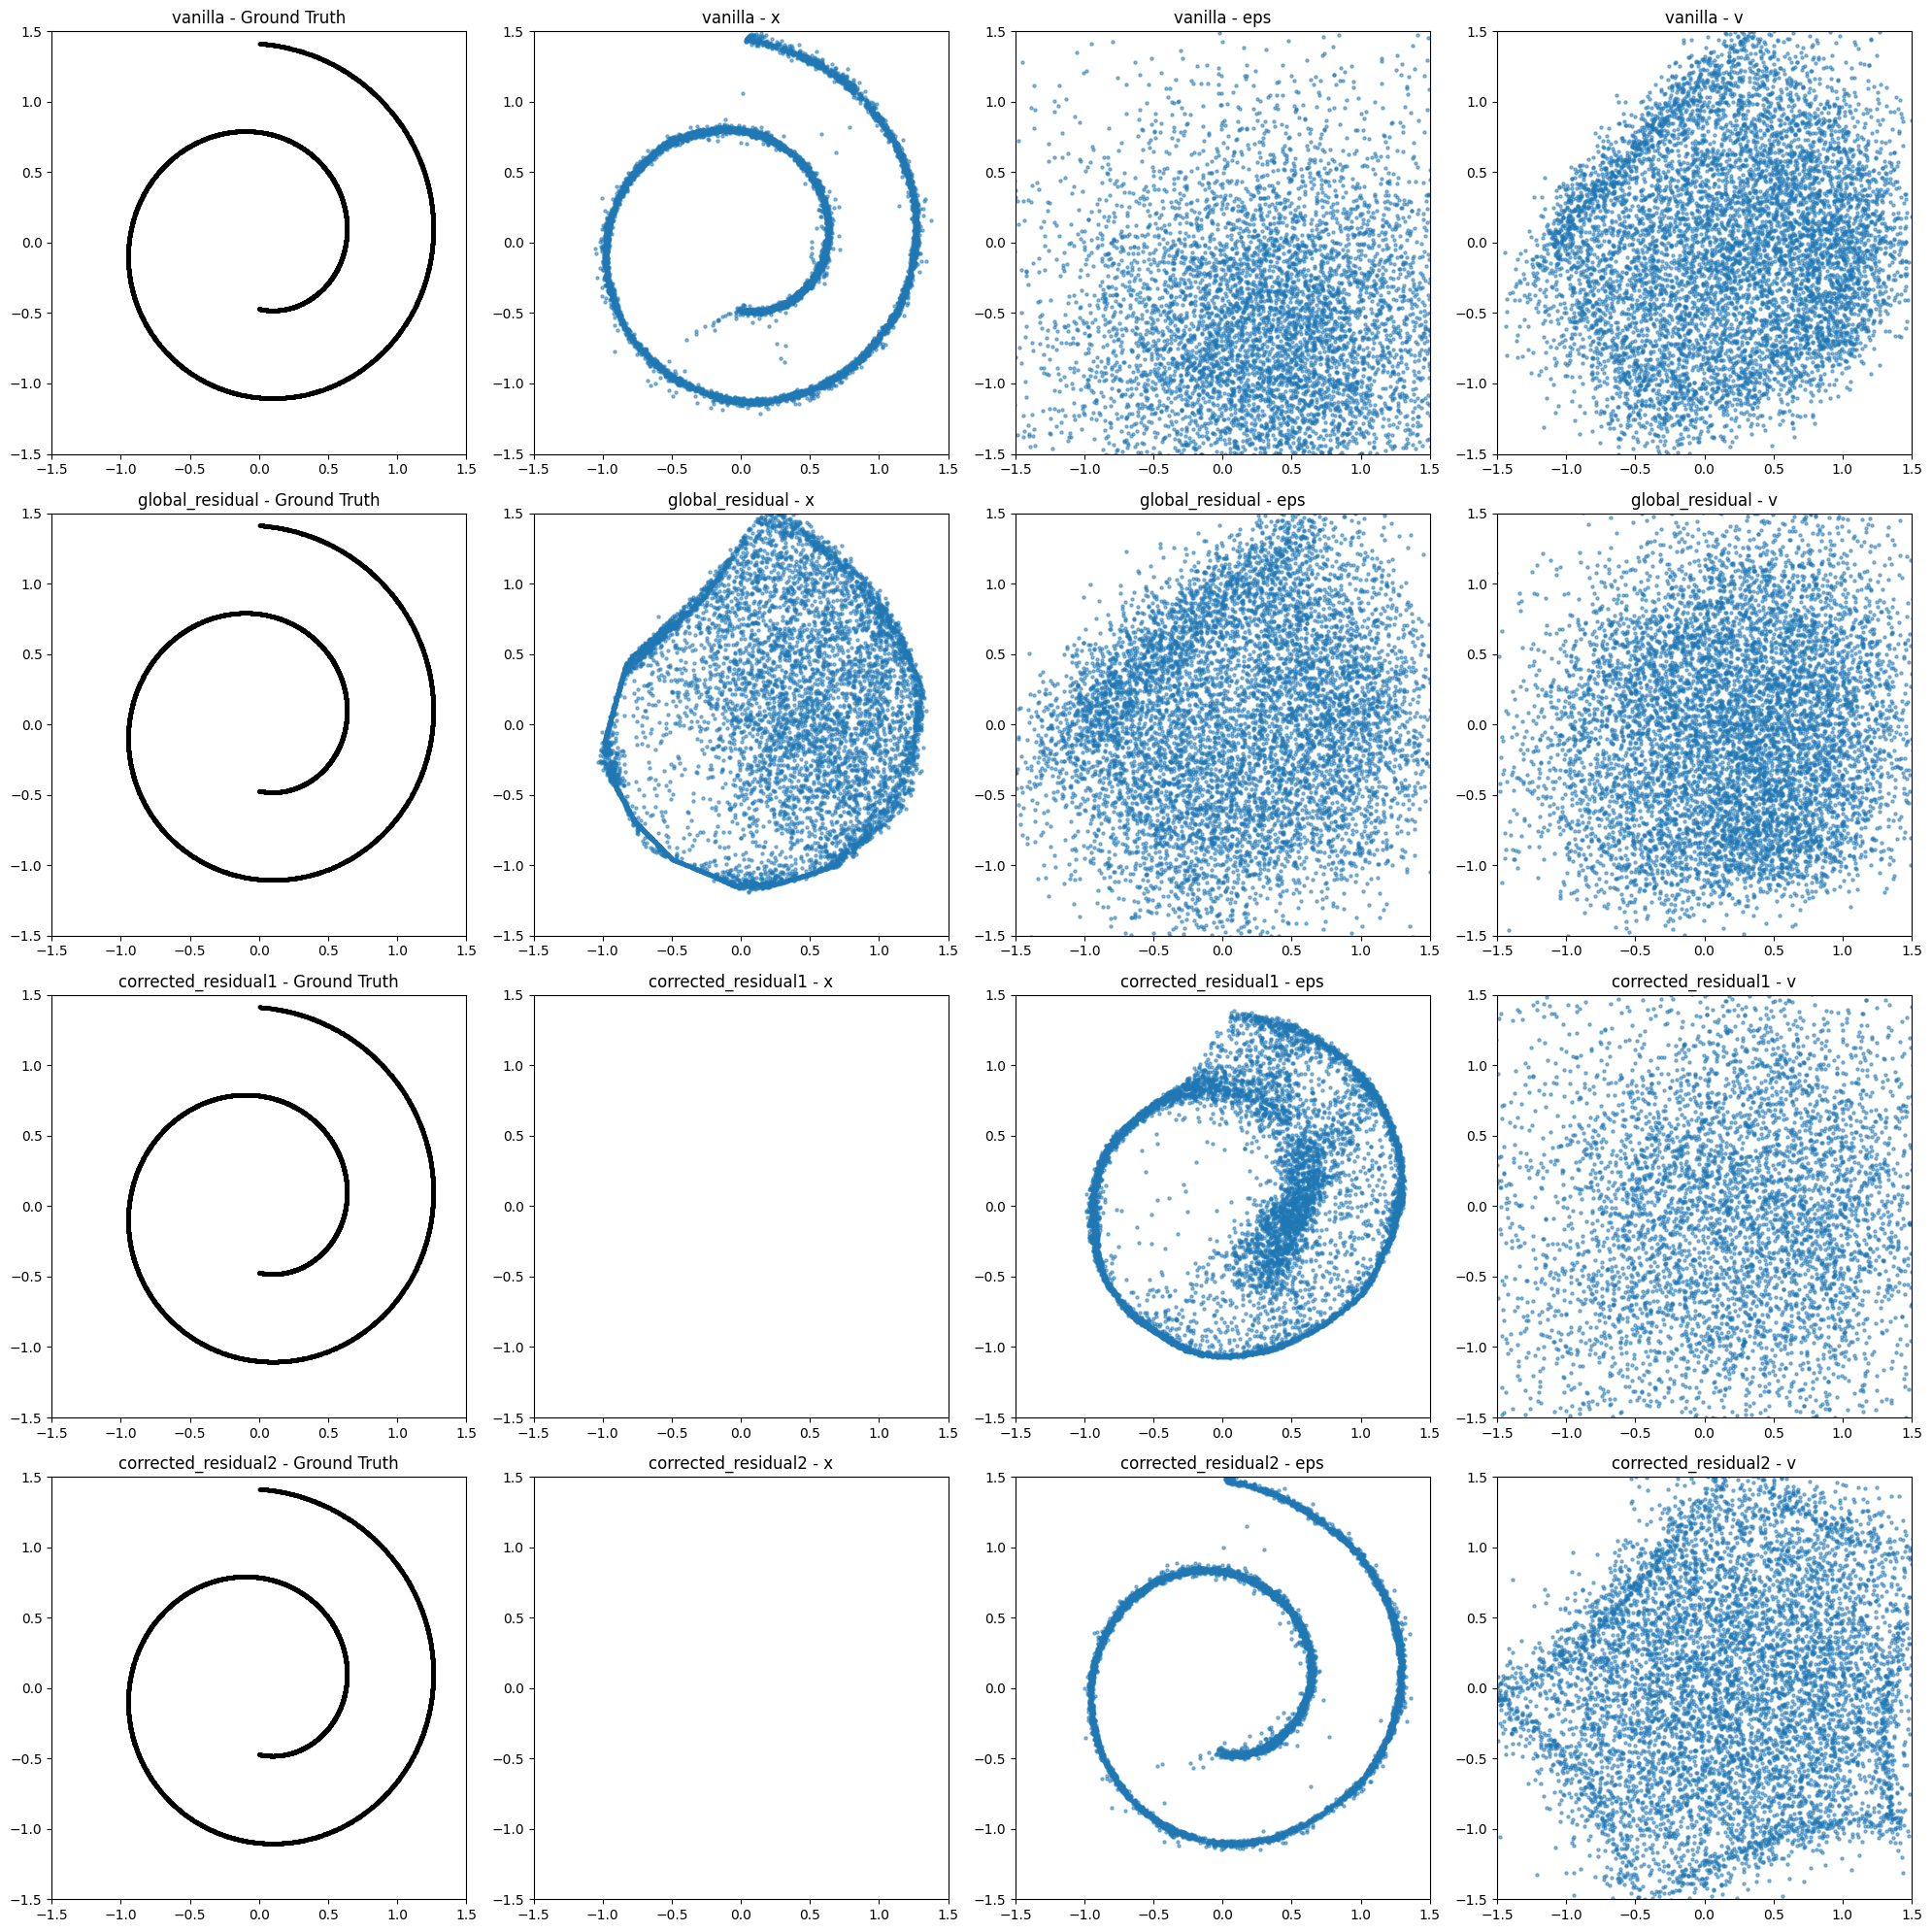

In [9]:
# ==========================================
# 7. Plot
# ==========================================

model_arches = list(dict.fromkeys([arch for arch, _ in experiments]))
cols = ["original", "x", "eps", "v"]

fig, axes = plt.subplots(len(model_arches), len(cols), figsize=(20, 5 * len(model_arches)))

if len(model_arches) == 1:
    axes = axes[None, :]  # ensure 2D indexing even for a single row

for row_idx, model_arch in enumerate(model_arches):
    axes[row_idx, 0].scatter(x_orig[:, 0], x_orig[:, 1], s=5, c="black", alpha=0.5)
    axes[row_idx, 0].set_title(f"{model_arch} - Ground Truth")

    for col_idx, pred_type in enumerate(["x", "eps", "v"], start=1):
        x_pred = x_preds[(model_arch, pred_type)]
        axes[row_idx, col_idx].scatter(x_pred[:, 0], x_pred[:, 1], s=5, alpha=0.5)
        axes[row_idx, col_idx].set_title(f"{model_arch} - {pred_type}")

for ax in axes.flat:
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)

plt.tight_layout()
plt.show()
